# Attention Comparison: Zero-Shot vs Fine-Tuned

**Goal:** Visualize what each model "looks at" when scoring the same chunk.

We compare:
- **Zero-Shot:** `cross-encoder/ms-marco-MiniLM-L-6-v2` (pre-trained, no fine-tuning)
- **Fine-Tuned:** Model trained on our dataset's quality labels


In [2]:
# ============================================
# COLAB SETUP
# ============================================
from google.colab import files
print("Upload Deep_Learning_Project.zip")
uploaded = files.upload()

!unzip -q -o Deep_Learning_Project.zip -d /content/

import os
os.chdir('/content/Deep_Learning_Project_local/notebooks')
print(f"Working directory: {os.getcwd()}")

!pip install -q transformers torch pandas matplotlib seaborn pyyaml

Upload Deep_Learning_Project.zip


Saving Deep_Learning_Project.zip to Deep_Learning_Project.zip
Working directory: /content/Deep_Learning_Project_local/notebooks


In [3]:
# ============================================
# IMPORTS AND SETUP
# ============================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer
from pathlib import Path
import yaml
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [4]:
# ============================================
# LOAD TEST DATA
# ============================================
TEST_DATA_DIR = Path('../data/test_dataset')
CONFIG_PATH = Path('../config/skills_test.yml')

# Load chunks and labels
chunks_df = pd.read_csv(TEST_DATA_DIR / 'transcript_chunks.csv')
labels_df = pd.read_csv(TEST_DATA_DIR / 'labeling/chunk_scores_gemini.csv')

# Merge - include skill_id
test_df = chunks_df.merge(
    labels_df[['chunk_id', 'skill_id', 'traditional_relevance']],
    on='chunk_id',
    how='inner'
)

# Load skills config for queries
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)
skills_map = {s['skill_id']: s for s in config['skills']}

print(f"Loaded {len(test_df)} test chunks")
print(f"Columns: {list(test_df.columns)}")

Loaded 193953 test chunks
Columns: ['chunk_id', 'text', 'token_count', 'start_sentence_idx', 'end_sentence_idx', 'video_id', 'skill_id', 'traditional_relevance']


In [5]:
# ============================================
# FILTER CHUNKS
# ============================================
# Remove intro/outro chunks, keep technical content

bad_phrases = [
    'hello everyone', 'welcome to', 'hey guys',
    'thanks for watching', 'subscribe', 'like and subscribe',
    'see you next', 'bye', 'hit the bell'
]

tech_terms = [
    'neural', 'network', 'model', 'train', 'layer',
    'tensor', 'gradient', 'loss', 'epoch', 'batch',
    'learning', 'api', 'deploy', 'flask', 'endpoint',
    'q-learning', 'reward', 'policy', 'agent', 'state'
]

def is_good_chunk(row):
    text_lower = row['text'].lower()

    # Skip bad phrases
    for phrase in bad_phrases:
        if phrase in text_lower:
            return False

    # Must have technical content
    if not any(term in text_lower for term in tech_terms):
        return False

    # Good length
    word_count = len(row['text'].split())
    if word_count < 50 or word_count > 200:
        return False

    return True

# Apply filter
test_df['is_good'] = test_df.apply(is_good_chunk, axis=1)

# Keep good chunks with decent relevance
good_chunks = test_df[
    (test_df['is_good']) &
    (test_df['traditional_relevance'] >= 3)
].copy()

# Drop duplicates by chunk_id
good_chunks = good_chunks.drop_duplicates(subset=['chunk_id'])

print(f"Good chunks after filtering: {len(good_chunks)}")
print(f"Sample:")
print(good_chunks[['chunk_id', 'skill_id', 'traditional_relevance']].head())

Good chunks after filtering: 64
Sample:
      chunk_id              skill_id  traditional_relevance
1328        12  model_deployment_api                    4.0
1736         0  model_deployment_api                    3.0
5625        16  model_deployment_api                    4.0
7999        18  model_deployment_api                    4.0
9574        15  model_deployment_api                    4.0


In [6]:
# ============================================
# SELECT REPRESENTATIVE CHUNKS (5 unique)
# ============================================
# Pick top chunks by relevance score
selected_chunks = good_chunks.nlargest(5, 'traditional_relevance')

print(f"Selected {len(selected_chunks)} chunks for visualization:")
for _, row in selected_chunks.iterrows():
    print(f"  Chunk {row['chunk_id']}: {row['text'][:80]}...")

Selected 5 chunks for visualization:
  Chunk 7: i can weight it by my quality function and that gives me the information i need ...
  Chunk 6: we just call the sample function and then convert that into by array on otherwis...
  Chunk 44: epsilon and we will pass this epsilon value to get action function now we have t...
  Chunk 71: looks like we're all good there and we've stopped all righty now the next thing ...
  Chunk 76: here we have mario bros for multi agents of luigi and mario here on the action s...


In [7]:
# ============================================
# LOAD MODELS WITH ATTENTION
# ============================================
print("Loading Zero-Shot model...")
tokenizer_zs = AutoTokenizer.from_pretrained('cross-encoder/ms-marco-MiniLM-L-6-v2')
model_zs = AutoModel.from_pretrained(
    'cross-encoder/ms-marco-MiniLM-L-6-v2',
    output_attentions=True
).to(device).eval()
print("Zero-Shot loaded!")

print("\nLoading Fine-Tuned model...")
MODEL_PATH = '../models/best_model_fold0'
tokenizer_ft = AutoTokenizer.from_pretrained(MODEL_PATH)
model_ft = AutoModel.from_pretrained(
    MODEL_PATH,
    output_attentions=True
).to(device).eval()
print("Fine-Tuned loaded!")

Loading Zero-Shot model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Zero-Shot loaded!

Loading Fine-Tuned model...
Fine-Tuned loaded!


In [8]:
# ============================================
# ATTENTION EXTRACTION (CHUNK TEXT ONLY)
# ============================================

def get_chunk_attention(model, tokenizer, query, text, device='cpu'):
    """
    Extract attention for the CHUNK TEXT only (not the query/description).
    """
    # Tokenize query + text together
    encoding = tokenizer(
        query, text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Get all tokens
    all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Get CLS attention (last layer, averaged across heads)
    attentions = outputs.attentions[-1][0]  # [heads, seq, seq]
    cls_attention = attentions[:, 0, :].mean(dim=0).cpu().numpy()

    # Find where chunk text starts (after first [SEP])
    try:
        sep_idx = all_tokens.index('[SEP]')
    except:
        sep_idx = 0

    # Get only chunk tokens (after first [SEP], before padding)
    mask = attention_mask[0].cpu().numpy()
    actual_len = int(mask.sum())

    chunk_tokens = all_tokens[sep_idx+1:actual_len]
    chunk_attention = cls_attention[sep_idx+1:actual_len]

    # Filter out special tokens and punctuation
    filtered = []
    special = ['[SEP]', '[CLS]', '[PAD]', '.', ',', '!', '?', "'", '"']
    for tok, att in zip(chunk_tokens, chunk_attention):
        if tok not in special and len(tok) > 1:
            # Clean subword tokens
            clean_tok = tok.replace('##', '')
            filtered.append((clean_tok, att))

    if not filtered:
        return [], []

    tokens, weights = zip(*filtered)
    return list(tokens), list(weights)

print("Attention extraction function ready!")

Attention extraction function ready!


In [ ]:
# ============================================
# VISUALIZATION FUNCTION (Sentence Order)
# ============================================

def plot_attention_comparison(tokens_zs, attn_zs, tokens_ft, attn_ft,
                               chunk_id, save_path=None):
    """
    Side-by-side attention comparison - tokens in SENTENCE ORDER.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))


    color_zs = 'coral'
    color_ft = 'mediumpurple'

    # Show first N tokens (in original order)
    max_tokens = 25

    # --- Zero-Shot (Left) ---
    ax = axes[0]
    if tokens_zs:
        # Keep original order, just limit to first N
        toks = tokens_zs[:max_tokens]
        atts = np.array(attn_zs[:max_tokens])

        # Normalize to 0-1
        if atts.max() > atts.min():
            atts_norm = (atts - atts.min()) / (atts.max() - atts.min())
        else:
            atts_norm = atts

        y_pos = range(len(toks))
        bars = ax.barh(y_pos, atts_norm, color=color_zs, alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(toks, fontsize=10)
        ax.invert_yaxis()  # First word at top
        ax.set_xlim(0, 1.15)

        # Add values on bars
        for i, (bar, val) in enumerate(zip(bars, atts_norm)):
            ax.text(val + 0.02, i, f'{val:.2f}', va='center', fontsize=9, fontweight='bold')

    ax.set_xlabel('Attention Weight (normalized)', fontsize=11)
    ax.set_title('Zero-Shot Model', fontsize=14, fontweight='bold', color=color_zs)
    ax.grid(axis='x', alpha=0.3)

    # --- Fine-Tuned (Right) ---
    ax = axes[1]
    if tokens_ft:
        toks = tokens_ft[:max_tokens]
        atts = np.array(attn_ft[:max_tokens])

        if atts.max() > atts.min():
            atts_norm = (atts - atts.min()) / (atts.max() - atts.min())
        else:
            atts_norm = atts

        y_pos = range(len(toks))
        bars = ax.barh(y_pos, atts_norm, color=color_ft, alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(toks, fontsize=10)
        ax.invert_yaxis()  # First word at top
        ax.set_xlim(0, 1.15)

        for i, (bar, val) in enumerate(zip(bars, atts_norm)):
            ax.text(val + 0.02, i, f'{val:.2f}', va='center', fontsize=9, fontweight='bold')

    ax.set_xlabel('Attention Weight (normalized)', fontsize=11)
    ax.set_title('Fine-Tuned Model', fontsize=14, fontweight='bold', color=color_ft)
    ax.grid(axis='x', alpha=0.3)

    plt.suptitle(f'Attention Comparison - Chunk {chunk_id}', fontsize=16, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")

    plt.show()

print("Visualization function ready!")

Visualization function ready!



Chunk 7
Text: i can weight it by my quality function and that gives me the information i need to update my my weights theta so i just ...

Zero-Shot top: ['compute', 'mathematical', 'okay', 'weight', 'theta']
Fine-Tuned top: ['weight', 'okay', 'theta', 'interested', 'propagation']
Saved: ../results/attention_comparison/attention_chunk_7.png


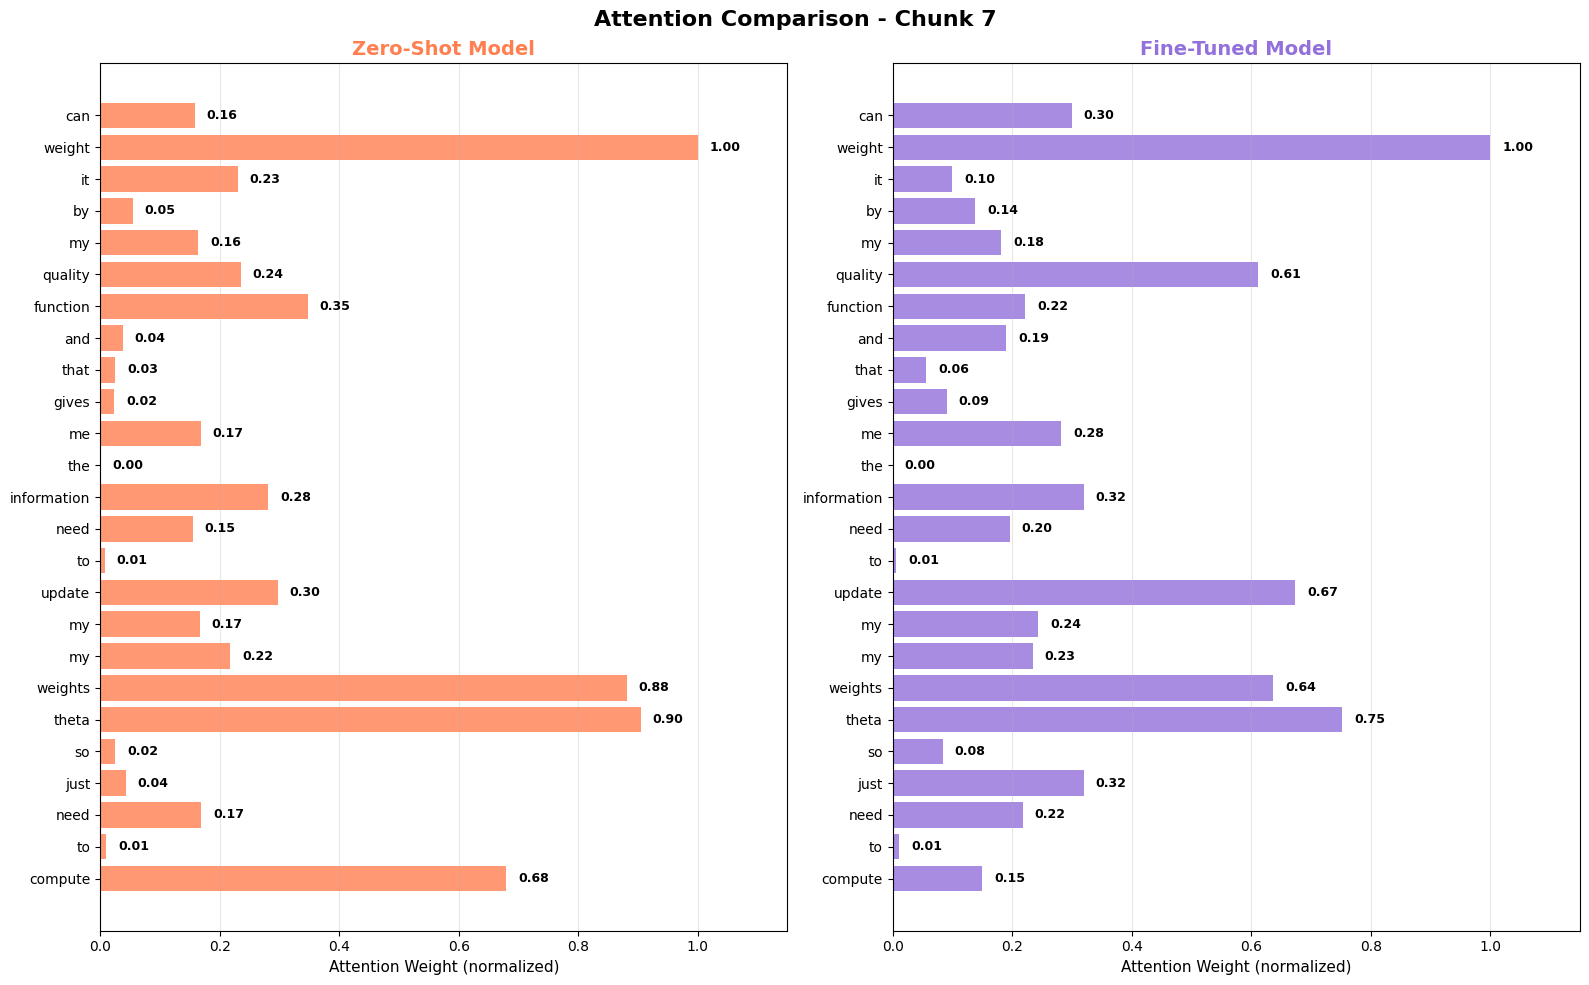


Chunk 6
Text: we just call the sample function and then convert that into by array on otherwise we use our q network so we get the q v...

Zero-Shot top: ['action', 'ara', 'okay', 'action', 'action']
Fine-Tuned top: ['feeding', 'observation', 'ara', 'action', 'nw']
Saved: ../results/attention_comparison/attention_chunk_6.png


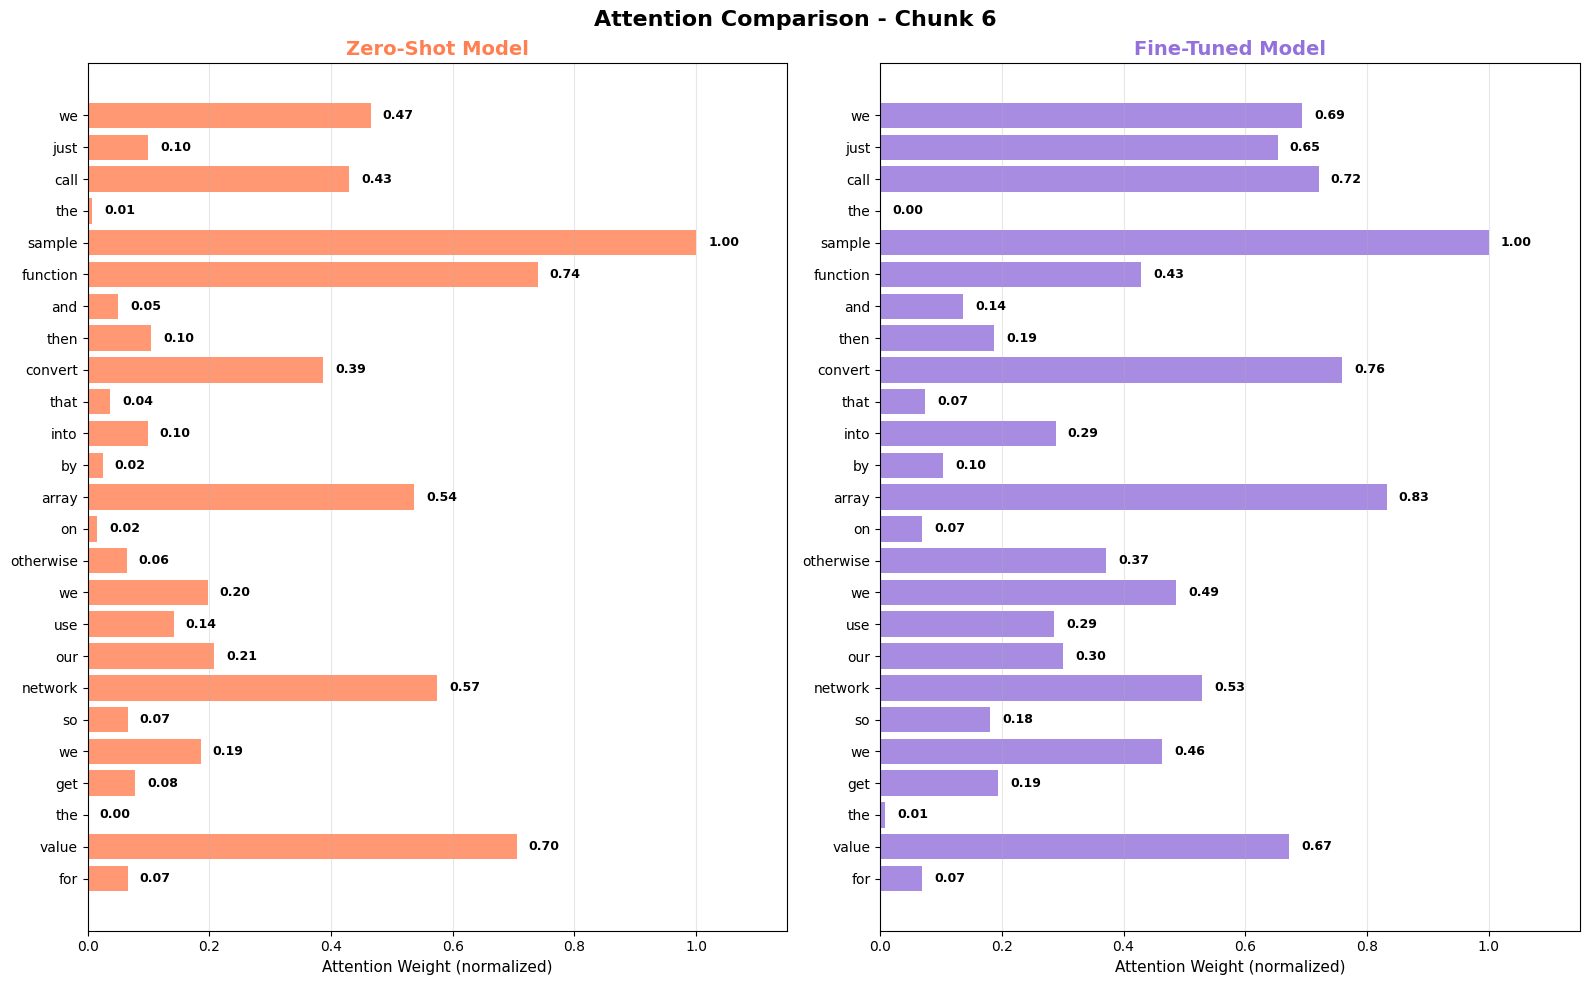


Chunk 44
Text: epsilon and we will pass this epsilon value to get action function now we have the action now agent needs to perform thi...

Zero-Shot top: ['value', 'four', 'size', 'epsilon', 'equal']
Fine-Tuned top: ['epsilon', 'remember', 'agent', 'epsilon', 'equal']
Saved: ../results/attention_comparison/attention_chunk_44.png


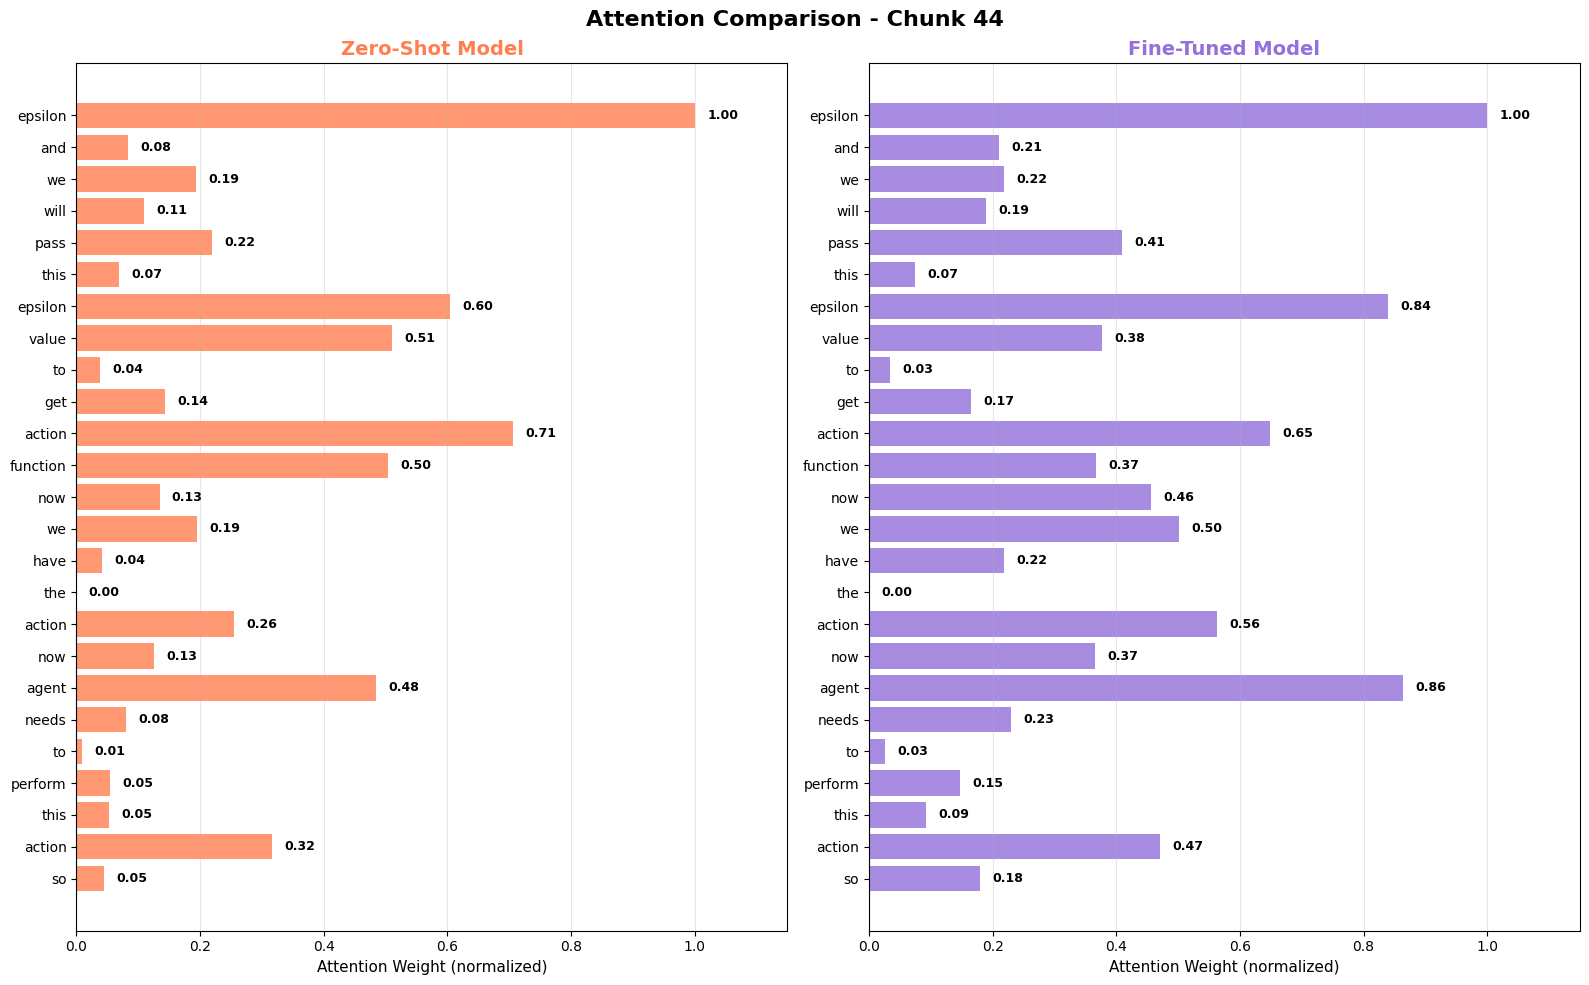


Chunk 71
Text: looks like we're all good there and we've stopped all righty now the next thing that we want to now do is actually take ...

Zero-Shot top: ['algorithm', 'example', 'dq', 'how', 'model']
Fine-Tuned top: ['looks', 'dq', 'how', 'alternate', 'algorithm']
Saved: ../results/attention_comparison/attention_chunk_71.png


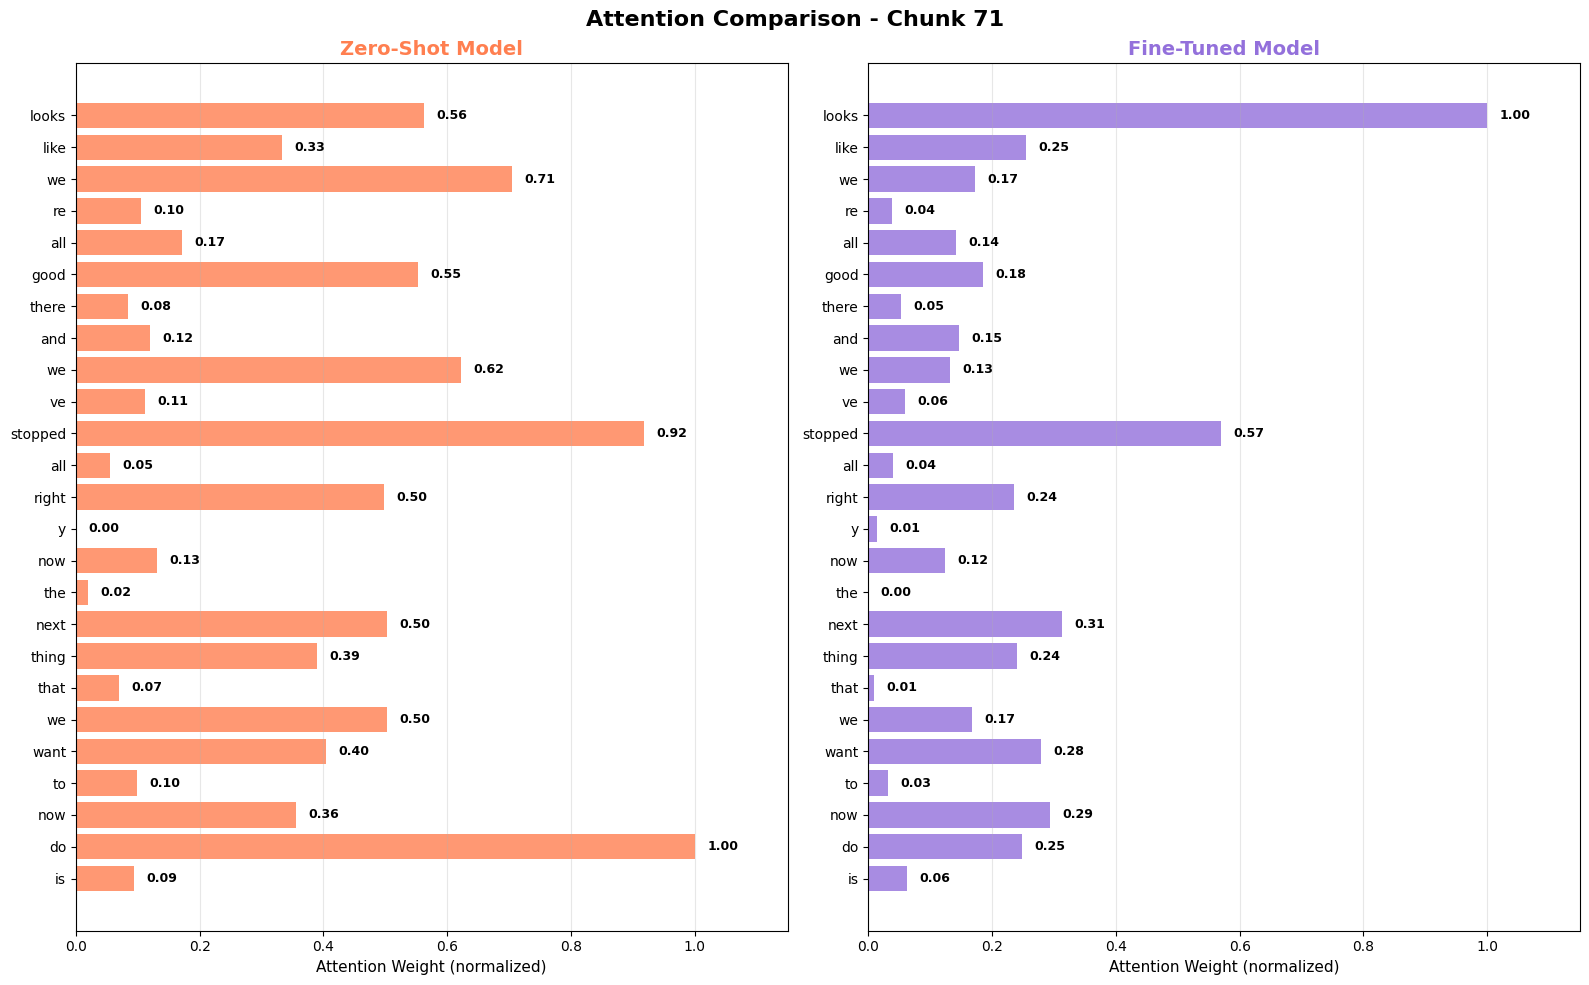


Chunk 76
Text: here we have mario bros for multi agents of luigi and mario here on the action space is defined so i've explained all th...

Zero-Shot top: ['mario', 'games', 'implementing', 'invaders', 'games']
Fine-Tuned top: ['invaders', 'mario', 'defined', 'space', 'multi']
Saved: ../results/attention_comparison/attention_chunk_76.png


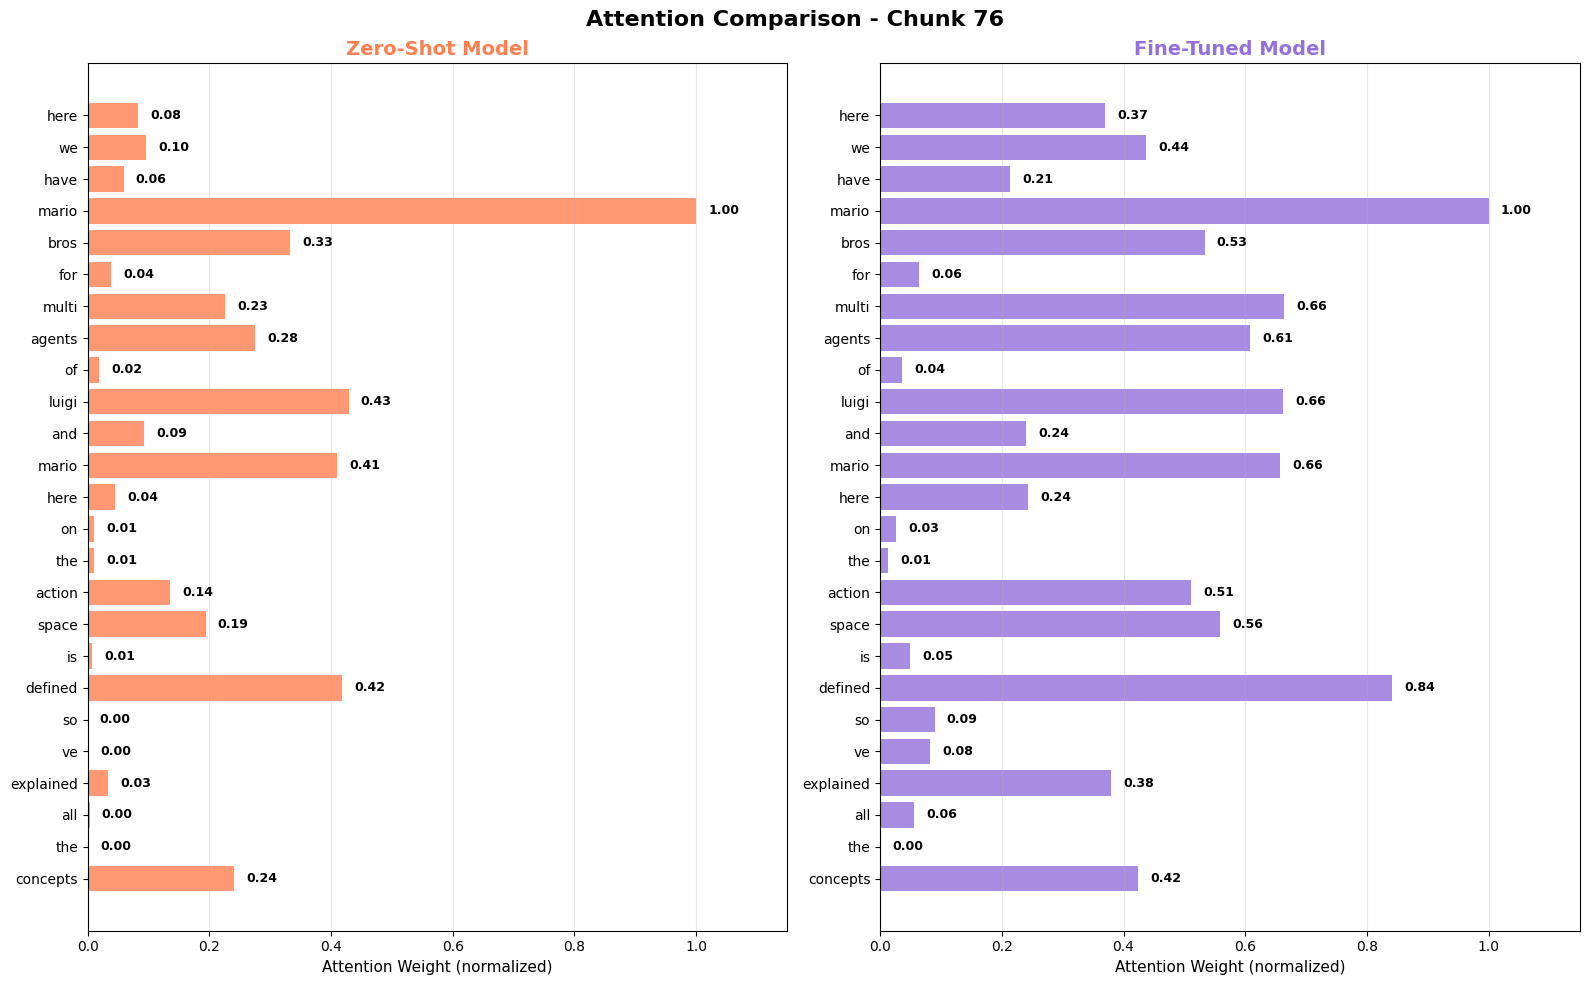

In [13]:
# ============================================
# GENERATE COMPARISONS
# ============================================
OUTPUT_DIR = Path('../results/attention_comparison')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

all_results = []

for idx, row in selected_chunks.iterrows():
    chunk_id = row['chunk_id']
    skill_id = row['skill_id']
    text = row['text']

    # Get skill query
    skill_info = skills_map[skill_id]
    query = f"{skill_info['name']}: {skill_info['description']}"

    print(f"\n{'='*60}")
    print(f"Chunk {chunk_id}")
    print(f"{'='*60}")
    print(f"Text: {text[:120]}...")

    # Extract attention
    tokens_zs, attn_zs = get_chunk_attention(model_zs, tokenizer_zs, query, text, device)
    tokens_ft, attn_ft = get_chunk_attention(model_ft, tokenizer_ft, query, text, device)

    # Show top tokens
    if tokens_zs:
        top_zs = sorted(zip(tokens_zs, attn_zs), key=lambda x: x[1], reverse=True)[:5]
        print(f"\nZero-Shot top: {[t[0] for t in top_zs]}")

    if tokens_ft:
        top_ft = sorted(zip(tokens_ft, attn_ft), key=lambda x: x[1], reverse=True)[:5]
        print(f"Fine-Tuned top: {[t[0] for t in top_ft]}")

    # Store results
    all_results.append({
        'chunk_id': chunk_id,
        'tokens_zs': tokens_zs,
        'attn_zs': attn_zs,
        'tokens_ft': tokens_ft,
        'attn_ft': attn_ft
    })

    # Create visualization
    save_path = OUTPUT_DIR / f'attention_chunk_{chunk_id}.png'
    plot_attention_comparison(tokens_zs, attn_zs, tokens_ft, attn_ft, chunk_id, save_path)